## preparing tokenized data

In [1]:
# import libraries
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
pd.set_option('display.max_colwidth', 80)

In [2]:
# read the json file into a dataframe
df = pd.read_json('reviews.json', lines=True)
data = df[["reviewText", "overall"]]

In [3]:
data.head()

,reviewText,overall
0,"This came in on time and I am veru happy with it, I haved used it already an...",5
1,"I had a factory Glock tool that I was using for my Glock 26, 27, and 17. I'...",5
2,"If you don't have a 3/32 punch or would like to have one in your Glock bag, ...",4
3,This works no better than any 3/32 punch you would find at the hardware stor...,4
4,I purchased this thinking maybe I need a special tool to easily pop off my b...,4


In [4]:
# the preprocess_documents function in gensim automatically stem
# which is not desired
# thus this customized gensim_strip function

#from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.parsing.preprocessing import strip_multiple_whitespaces

def gensim_strip(input_data):
    input_data = input_data.lower()
    input_data = strip_tags(input_data)
    input_data = strip_short(input_data, minsize = 3)
    input_data = strip_punctuation(input_data)
    input_data = strip_numeric(input_data)
    input_data = strip_non_alphanum(input_data)
    input_data = strip_multiple_whitespaces(input_data)
    return input_data

In [5]:
import spacy

# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load("en_core_web_sm")

In [6]:
# preprocess text using strip and lemmatization
def tokenvec(line):
    line = gensim_strip(line)
    doc = nlp(line)
    doc = [token.lemma_ for token in doc]
    return [token for token in doc if len(token) >= 3]

In [7]:
reviewText_token = []
#summary_token = []
for index, row in data.iterrows():
    reviewText_token.append(tokenvec(row['reviewText']))
    #summary_token.append(tokenvec(row['summary']))
data['tokenized review'] = reviewText_token
#data['tokenized summary'] = summary_token
data.head()

/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_27608/3662229646.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tokenized review'] = reviewText_token


,reviewText,overall,tokenized review
0,"This came in on time and I am veru happy with it, I haved used it already an...",5,"[this, come, time, and, veru, happy, with, have, use, already, and, make, ta..."
1,"I had a factory Glock tool that I was using for my Glock 26, 27, and 17. I'...",5,"[have, factory, glock, tool, that, use, for, glock, and, since, lose, and, h..."
2,"If you don't have a 3/32 punch or would like to have one in your Glock bag, ...",4,"[you, don, have, punch, would, like, have, one, your, glock, bag, this, okay..."
3,This works no better than any 3/32 punch you would find at the hardware stor...,4,"[this, work, well, than, any, punch, you, would, find, the, hardware, store,..."
4,I purchased this thinking maybe I need a special tool to easily pop off my b...,4,"[purchase, this, thinking, maybe, need, special, tool, easily, pop, off, bas..."


In [8]:
df = data[['overall', 'tokenized review']]
df.head()

,overall,tokenized review
0,5,"[this, come, time, and, veru, happy, with, have, use, already, and, make, ta..."
1,5,"[have, factory, glock, tool, that, use, for, glock, and, since, lose, and, h..."
2,4,"[you, don, have, punch, would, like, have, one, your, glock, bag, this, okay..."
3,4,"[this, work, well, than, any, punch, you, would, find, the, hardware, store,..."
4,4,"[purchase, this, thinking, maybe, need, special, tool, easily, pop, off, bas..."


## get TF-IDF weight

In [11]:
# data list for tf-idf modeling
corpus = []
for index, row in df.iterrows():
    corpus.append(" ".join([token for token in row['tokenized review']]))

In [12]:
# tf-idf model
from sklearn.feature_extraction.text import TfidfVectorizer

# in total the vocab size is over 90k 
# we will only consider the most frequent 2000 words in order to prevent overfitting
vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 2000) 
X = vectorizer.fit_transform(corpus)
X = X.toarray()

In [13]:
# the dictionary consists of the 2000 frequent words as keys
# and their corresponnding indices as values
vocab = vectorizer.vocabulary_

## word2vec modeling

In [14]:
# Split data into train and test sets
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(df['tokenized review'], 
                                                    df['overall'],
                                                    test_size=0.2, random_state = SEED)

In [18]:
# Train the word2vec model based on reviewText
w2v_model = gensim.models.Word2Vec(df['tokenized review'],
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

In [20]:
w2v_model.wv.index_to_key[100:110]

['then',
 'purchase',
 'around',
 'water',
 'day',
 'love',
 'handle',
 'carry',
 'set',
 'how']

In [21]:
# Find the most similar words to "great" based on word vectors from our trained model
w2v_model.wv.most_similar('great')

[('fantastic', 0.8686527609825134),
 ('excellent', 0.8195327520370483),
 ('awesome', 0.7877996563911438),
 ('good', 0.7609325647354126),
 ('wonderful', 0.7363530993461609),
 ('nice', 0.6698836088180542),
 ('terrific', 0.6649855375289917),
 ('perfect', 0.6524454951286316),
 ('decent', 0.6352002024650574),
 ('amazing', 0.6348913311958313)]

In [31]:
words = set(w2v_model.wv.index_to_key)
default = np.zeros(100, dtype=float)

# return the w2v vec of a word
# output shape = (100,)
def vec_of_word(word):
    if word not in words:
        return default
    else:
        return w2v_model.wv[word]

# return the averaged vec of a review
# output shape = (100,)
def vec_of_review(row_idx):
    review = df['tokenized review'][row_idx]
    v = []
    for word in review:
        if word in words:
            v.append(vec_of_word(word))
    v = np.array(v)
    return v.mean(axis=0) if v.size else default

# returns the weighted vec of a word 
# where the vec comes from w2v model
# the weight is from tf-idf
# output shape = (100,)
def weighted_vec_of_word(word, row_idx):
    if word not in vocab or word not in words:
        return default
    else:
        index = vocab[word]
        return w2v_model.wv[word] * X[row_idx][index]

# returns the averaged weighted vec of a review
# output shape = (100,)
def weighted_vec_of_review(row_idx):
    review = df['tokenized review'][row_idx]
    v = []
    for word in review:
        if word in vocab and word in words:
            v.append(weighted_vec_of_word(word, row_idx))
    v = np.array(v)
    return v.mean(axis=0) if v.size else default

In [32]:
review_vec, review_vec_weighted = [], []

for row_idx in range(df.shape[0]):
    review_vec.append(np.array(vec_of_review(row_idx)))
    review_vec_weighted.append(np.array(weighted_vec_of_review(row_idx)))

In [37]:
review_vec = np.array(review_vec)
review_vec_weighted = np.array(review_vec_weighted)

In [26]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg_review, y_train)

In [27]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg_review)

In [28]:
y_pred[:20]

array([5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6498953904299116

In [30]:
# Use the trained model to make predictions on the test data
y_pred_s = rf_model.predict(X_test_vect_avg_summary)

In [31]:
accuracy_score(y_test, y_pred_s)

0.5809543092393872

Therefore we will proceeed whith the vecs from the review text.

## classification using neural net -- without tf-idf weighting

In [39]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split

In [40]:
# split the data to train, validation, and test
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(review_vec, df['overall'].tolist(), 
                                                  test_size=0.2, 
                                                  shuffle=True,
                                                 random_state = SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.15, 
                                                  shuffle=True,
                                                 random_state = SEED)

In [41]:
y_train = [x - 1 for x in y_train]
y_val = [x - 1 for x in y_val]
y_test = [x - 1 for x in y_test]

In [43]:
# prepare data for keras
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [44]:
train

<_TensorSliceDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [45]:
train = train.batch(32)
val = val.batch(32)

In [46]:
AUTOTUNE = tf.data.AUTOTUNE
#BATCH_SIZE = 32
train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

In [90]:
#define our model

model = Sequential()
model.add(layers.Dense(128, input_shape=(100,), activation='softmax'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='softmax'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(5, activation='softmax'))

#model.build((32, 100))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               12928     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 5)                 325       
                                                                 
Total params: 21509 (84.02 KB)
Trainable params: 21509 (84.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',
              metrics=['accuracy'])

In [92]:
#start training
epochs = 20

checkpoint_filepath = './checkpoint.model2.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=0)

history = model.fit(
    train,
    validation_data=val,
    epochs=epochs,
    batch_size=32,
    callbacks=[model_checkpoint_callback, earlystop_callback])

Epoch 1/20
6298/6298 [==============================] - 5s 735us/step - loss: 1.0003 - accuracy: 0.6357 - val_loss: 0.9144 - val_accuracy: 0.6415
Epoch 2/20
6298/6298 [==============================] - 4s 713us/step - loss: 0.9184 - accuracy: 0.6427 - val_loss: 0.8821 - val_accuracy: 0.6536
Epoch 3/20
6298/6298 [==============================] - 5s 720us/step - loss: 0.8987 - accuracy: 0.6501 - val_loss: 0.8732 - val_accuracy: 0.6566
Epoch 4/20
6298/6298 [==============================] - 4s 710us/step - loss: 0.8892 - accuracy: 0.6522 - val_loss: 0.8679 - val_accuracy: 0.6577
Epoch 5/20
6298/6298 [==============================] - 5s 716us/step - loss: 0.8830 - accuracy: 0.6531 - val_loss: 0.8630 - val_accuracy: 0.6595
Epoch 6/20
6298/6298 [==============================] - 4s 710us/step - loss: 0.8784 - accuracy: 0.6541 - val_loss: 0.8595 - val_accuracy: 0.6615
Epoch 7/20
6298/6298 [==============================] - 5s 720us/step - loss: 0.8743 - accuracy: 0.6558 - val_loss: 0.8577 -

## evaluate model perfomance -- without tf-idf weighting

In [50]:
test = test.batch(32)

In [51]:
loss, accuracy = model.evaluate(test)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1853/1853 [==============================] - 1s 331us/step - loss: 0.8504 - accuracy: 0.6637
Loss:  0.8503571152687073
Accuracy:  0.6637139916419983


In [52]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

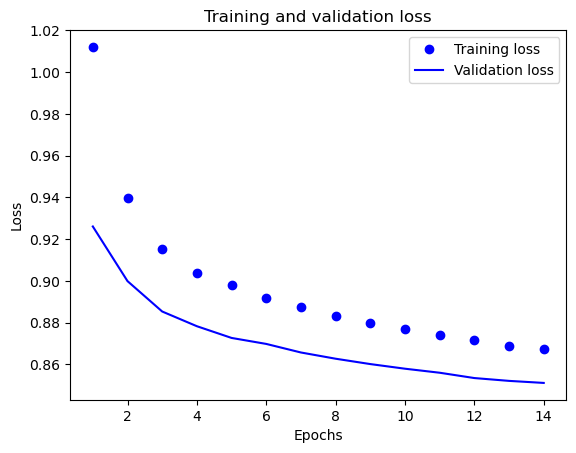

In [53]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

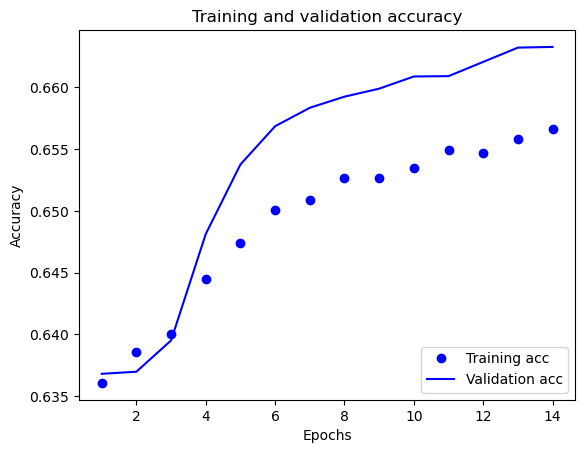

In [54]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [55]:
export_model = tf.keras.Sequential([
  model,
  layers.Activation('softmax')
])

export_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(test)
print(accuracy)

1853/1853 [==============================] - 1s 318us/step - loss: 1.3047 - accuracy: 0.6637
0.6637139916419983


## classification using neural net -- with tf-idf weighting

In [57]:
# split the data to train, validation, and test
SEED = 42
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(review_vec_weighted, df['overall'].tolist(), 
                                                  test_size=0.2, 
                                                  shuffle=True,
                                                 random_state = SEED)
X_train_w, X_val_w, y_train_w, y_val_w = train_test_split(X_train_w, y_train_w, 
                                                  test_size=0.15, 
                                                  shuffle=True,
                                                 random_state = SEED)

In [58]:
y_train_w = [x - 1 for x in y_train_w]
y_val_w = [x - 1 for x in y_val_w]
y_test_w = [x - 1 for x in y_test_w]

In [59]:
# prepare data for keras
train_w = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
val_w = tf.data.Dataset.from_tensor_slices((X_val_w, y_val_w))
test_w = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))

In [60]:
train_w = train_w.batch(32)
val_w = val_w.batch(32)

In [61]:
AUTOTUNE = tf.data.AUTOTUNE
#BATCH_SIZE = 32
train_w = train_w.cache().prefetch(buffer_size=AUTOTUNE)
val_w = val_w.cache().prefetch(buffer_size=AUTOTUNE)
test_w = test_w.cache().prefetch(buffer_size=AUTOTUNE)

In [84]:
#define our model
# using same specs of the model for unweighted vecs

model_w = Sequential()
model_w.add(layers.Dense(128, input_shape=(100,), activation='softmax'))
model_w.add(layers.Dropout(0.2))
model_w.add(layers.Dense(64, activation='softmax'))
model_w.add(layers.Dropout(0.1))
model_w.add(layers.Dense(5, activation='softmax'))

#model.build((32, 100))
model_w.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 128)               12928     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 5)                 325       
                                                                 
Total params: 21509 (84.02 KB)
Trainable params: 21509 (84.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [85]:
model_w.compile(loss="sparse_categorical_crossentropy",optimizer='adam',
              metrics=['accuracy'])

In [86]:
#start training
epochs = 20

checkpoint_filepath = './checkpoint.model_w.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=0)

history = model_w.fit(
    train_w,
    validation_data=val_w,
    epochs=epochs,
    batch_size=32,
    callbacks=[model_checkpoint_callback, earlystop_callback])

Epoch 1/20
6298/6298 [==============================] - 5s 722us/step - loss: 1.0249 - accuracy: 0.6327 - val_loss: 0.9650 - val_accuracy: 0.6355
Epoch 2/20
6298/6298 [==============================] - 4s 708us/step - loss: 0.9622 - accuracy: 0.6341 - val_loss: 0.9488 - val_accuracy: 0.6354
Epoch 3/20
6298/6298 [==============================] - 5s 737us/step - loss: 0.9481 - accuracy: 0.6361 - val_loss: 0.9376 - val_accuracy: 0.6394
Epoch 4/20
6298/6298 [==============================] - 5s 827us/step - loss: 0.9407 - accuracy: 0.6371 - val_loss: 0.9324 - val_accuracy: 0.6401
Epoch 5/20
6298/6298 [==============================] - 5s 717us/step - loss: 0.9352 - accuracy: 0.6381 - val_loss: 0.9289 - val_accuracy: 0.6404
Epoch 6/20
6298/6298 [==============================] - 5s 717us/step - loss: 0.9312 - accuracy: 0.6386 - val_loss: 0.9258 - val_accuracy: 0.6416
Epoch 7/20
6298/6298 [==============================] - 5s 765us/step - loss: 0.9276 - accuracy: 0.6394 - val_loss: 0.9230 -

## evaluate model perfomance -- with tf-idf weighting

In [65]:
test_w = test_w.batch(32)

In [87]:
loss, accuracy = model_w.evaluate(test_w)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1853/1853 [==============================] - 1s 394us/step - loss: 0.9096 - accuracy: 0.6472
Loss:  0.909603476524353
Accuracy:  0.6471788883209229


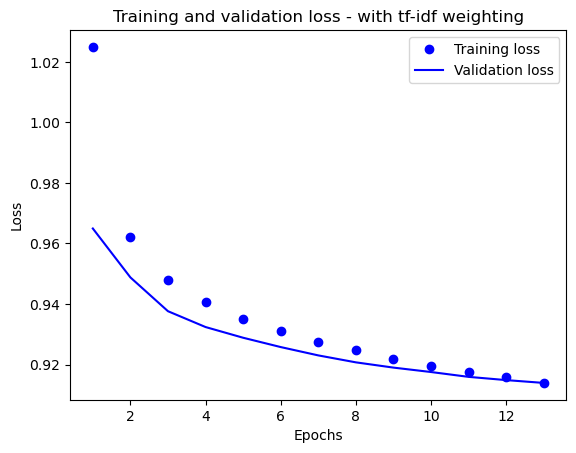

In [88]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss - with tf-idf weighting')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

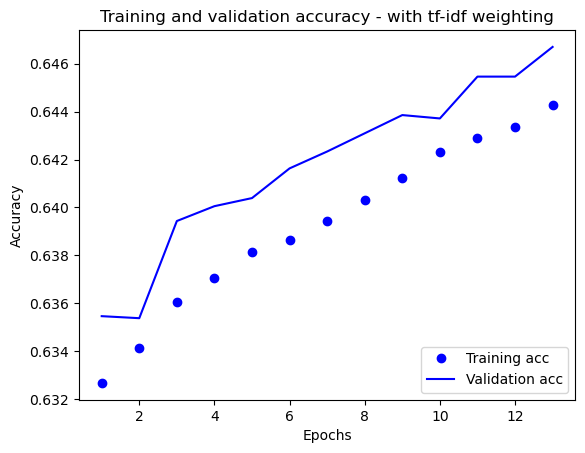

In [89]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy - with tf-idf weighting')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()